# Quadratic Linear Analysis (QDA)

**Objective**:
 demonstrate how QDA works for classification.

**Assumptions**
- all features are normal distributed.
- all features are uncorrelated
- ~~all classes displays the same covariance matrix~~

In [108]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
from sklearn.model_selection import train_test_split

## Example 1: two predictors with differente correlation matrices

Creating the data

            xA         xB         fx  y
537  17.141467 -12.402730   4.738736  1
571  20.371952  -2.864881  17.507071  1
77    8.915731 -10.522882  -1.607151  0
261  11.327308 -13.257831  -1.930523  0
923  16.204832 -17.055482  -0.850650  0


<AxesSubplot:xlabel='value', ylabel='Count'>

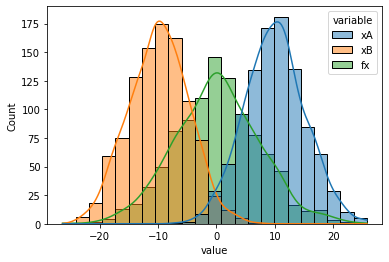

In [2]:
#features X
meanA, stdA = 10, 5
xA = np.random.normal(meanA, stdA, 1000)

meanB, stdB = -10, 5
xB = np.random.normal(meanB, stdB, 1000)

#target y
fx = xA + xB
y = [1 if i >= (meanA + meanB) else 0 for i in fx]

#data with X an y
data = pd.DataFrame({'xA':xA, 'xB':xB, 'fx': fx, 'y':y})
print(data.sample(5))

sns.histplot(data=pd.melt(data, id_vars=['y'], value_vars=['xA', 'xB', 'fx']), x='value', hue='variable', kde=True)

### Manual QDA

Checking the covariance matrices

In [3]:
#separing the data
sample0 = data.loc[data['y'] == 0]
sample1 = data.loc[data['y'] == 1]
assert data.shape[0] == sample0.shape[0] + sample1.shape[0]

#calculating the covariance matrices
print(sample0[['xA', 'xB']].cov())
print(sample1[['xA', 'xB']].cov())

           xA         xB
xA  17.767949  -8.097322
xB  -8.097322  17.862263
           xA         xB
xA  18.682219  -7.333267
xB  -7.333267  17.429247


The results above shows the differente between the covariance matrices, which is an indication that QDA should be a better suggestion. Since the QDA's decision function is a curve, it would allow more flexibility than the LDA's decision function, which is a straight line, thus resulting in lower bias.

QDA's decision function:

<img src="img/qda_decision_function.PNG" />

*source: https://www.statlearning.com/*

In [4]:
def preparation(df):
    '''calculate every variable (except x and xt) necessary for the decision equation'''

    sample0 = data.loc[data['y'] == 0]
    sample1 = data.loc[data['y'] == 1]

    m0 = sample0[['xA','xB']].mean().array.reshape(2,1)
    m0_t = sample0[['xA','xB']].mean().array
    m1 = sample1[['xA','xB']].mean().array.reshape(2,1)
    m1_t = sample1[['xA','xB']].mean().array

    cov0 = sample0[['xA', 'xB']].cov().to_numpy()
    cov0_inv = np.linalg.inv(sample0[['xA', 'xB']].cov())
    cov1 = sample1[['xA', 'xB']].cov().to_numpy()
    cov1_inv = np.linalg.inv(sample1[['xA', 'xB']].cov())

    ln0, ln1 = np.log(np.linalg.det(cov0)), np.log(np.linalg.det(cov1))
    prob0, prob1 = np.log((sample0.shape[0]/data.shape[0])), np.log((sample1.shape[0]/data.shape[0]))

    return m0, m0_t, m1, m1_t, cov0_inv, cov1_inv, ln0, ln1, prob0, prob1


#calculating each variable of the equation
m0, m0_t, m1, m1_t, cov0_inv, cov1_inv, ln0, ln1, prob0, prob1 = preparation(data)

In [5]:
def decision_function(x, x_t, m, m_t, cov_inv, ln, prob):
    '''create the function for each row'''
    fx = -0.5 * np.matmul(np.matmul(x_t, cov_inv), x) + \
              + np.matmul(np.matmul(x_t, cov_inv), m) + \
         -0.5 * np.matmul(np.matmul(m_t, cov_inv), m) + \
         -0.5 * ln + prob               
    return fx[0]


#calculating the decision function
data['manual_fx0'] = np.nan
data['manual_fx1'] = np.nan
data['manual_decision_function'] = np.nan
data['manual_prediction'] = np.nan

for index, row in data.iterrows():
    x_t = data[['xA','xB']].loc[index].array
    x = data[['xA','xB']].loc[index].array.reshape(2,1)

    data.loc[index, 'manual_fx0'] = decision_function(x, x_t, m0, m0_t, cov0_inv, ln0, prob0)
    data.loc[index, 'manual_fx1'] = decision_function(x, x_t, m1, m1_t, cov1_inv, ln1, prob1)
    data['manual_decision_function'] = data['manual_fx1'] - data['manual_fx0']
    data['manual_prediction'] = np.where(data['manual_fx1'] >= data['manual_fx0'], 1, 0)

data.sample(3)

,xA,xB,fx,y,manual_fx0,manual_fx1,manual_decision_function,manual_prediction
45,12.094415,-3.022317,9.072098,1,-9.245279,-3.975468,5.269811,1
965,1.686836,-9.609984,-7.923148,0,-4.296304,-8.473557,-4.177253,0
289,2.309022,-7.440453,-5.131431,0,-4.442946,-7.160729,-2.717783,0


In [6]:
#comparing the results
print(confusion_matrix(data['y'], data['manual_prediction']))
print(accuracy_score(data['y'], data['manual_prediction']))
print(precision_score(data['y'], data['manual_prediction']))
print(recall_score(data['y'], data['manual_prediction']))

[[491   2]
 [  0 507]]
0.998
0.9960707269155207
1.0


Something is wrong with the formula. Doing some investigation.

### Sklearn QDA

In [7]:
X = data[['xA','xB']]
y = data['y']

qda = QuadraticDiscriminantAnalysis(store_covariance=True)
qda.fit(X, y)

data['fx0_sklearn'] = qda.predict_log_proba(X)[:, 0]
data['fx1_sklearn'] = qda.predict_log_proba(X)[:, 1]
data['sklearn_decision_function'] = qda.decision_function(X)
data['sklearn_prediction'] = qda.predict(X)

In [8]:
data.sample(3)

,xA,xB,fx,y,manual_fx0,manual_fx1,manual_decision_function,manual_prediction,fx0_sklearn,fx1_sklearn,sklearn_decision_function,sklearn_prediction
192,10.494996,-9.651591,0.843404,1,-4.556738,-4.057672,0.499066,1,-0.973495,-0.474430,0.499066,1
444,16.345449,-4.320168,12.025281,1,-11.514844,-4.386779,7.128065,1,-7.128867,-0.000802,7.128065,1
863,8.032330,-15.773676,-7.741347,0,-3.742399,-7.975157,-4.232758,0,-0.014408,-4.247166,-4.232758,0


[[491   2]
 [  0 507]]
0.998
0.9960707269155207
1.0


<AxesSubplot:xlabel='manual_decision_function', ylabel='sklearn_decision_function'>

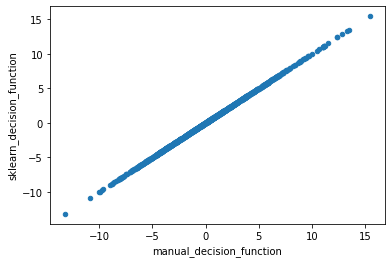

In [9]:
# Comparing the results.
print(confusion_matrix(data['y'], data['sklearn_prediction']))
print(accuracy_score(data['y'], data['sklearn_prediction']))
print(precision_score(data['y'], data['sklearn_prediction']))
print(recall_score(data['y'], data['sklearn_prediction']))

data.plot(x='manual_decision_function', y='sklearn_decision_function', kind='scatter')

In [10]:
#calculating the covariance matrices
print(sample0[['xA', 'xB']].cov())
print(sample1[['xA', 'xB']].cov())

qda.covariance_

           xA         xB
xA  17.767949  -8.097322
xB  -8.097322  17.862263
           xA         xB
xA  18.682219  -7.333267
xB  -7.333267  17.429247


[array([[17.76794862, -8.09732193],
        [-8.09732193, 17.86226285]]),
 array([[18.68221886, -7.33326705],
        [-7.33326705, 17.42924658]])]

As predicted, sklearn's QDA uses separately both sample's correlation matrices.

## Comparison LDA vs QDA

In theory, both algorithms follows the same logic and the only difference is the covariance matrix: LDA assumes the same covariance but QDA don't. In the next steps, we will analyse the impact of different samples in the classification performance. In the example, let's use Stranger Things for context.


### Data availability: plenty   

In [136]:
# Creating dummy data
early_dart = np.random.normal(10, 20, 1000)
late_dart = np.random.normal(30, 20, 1000)
demogorgon = np.random.normal(100, 20, 1000)
mind_flayer = np.random.normal(1000, 100, 1000)

fx = early_dart + late_dart + demogorgon + mind_flayer
bad_guys_win = [1 if i >= 1131 else 0 for i in fx]

#data with X an y
data = pd.DataFrame({'x1':early_dart, 'x2':late_date, 'x3': demogorgon, 'x4':mind_flayer, 'y':bad_guys_win})
print(data.sample(5))

            x1         x2          x3           x4  y
828  16.487879  50.571093  102.547351  1112.071097  1
387  29.036685  40.142777  115.863423   920.269127  0
501   0.199860  45.514920  122.909863   914.068573  0
676   9.253344  50.882602  111.472776  1219.519334  1
51    2.797447  50.374950   87.753519  1036.407755  1


In [137]:
data['y'].value_counts()

1    558
0    442
Name: y, dtype: int64

In [138]:
X = data.drop(columns='y')
y = data['y']

lda = LinearDiscriminantAnalysis().fit(X, y)
qda = QuadraticDiscriminantAnalysis().fit(X, y)

In [139]:
# LDA
print(confusion_matrix(data['y'], lda.predict(X)))
print(accuracy_score(data['y'], lda.predict(X)))
print(precision_score(data['y'], lda.predict(X)))
print(recall_score(data['y'], lda.predict(X)))

# QDA
print(confusion_matrix(data['y'], qda.predict(X)))
print(accuracy_score(data['y'], qda.predict(X)))
print(precision_score(data['y'], qda.predict(X)))
print(recall_score(data['y'], qda.predict(X)))

[[401  41]
 [ 25 533]]
0.934
0.9285714285714286
0.9551971326164874
[[404  38]
 [ 29 529]]
0.933
0.9329805996472663
0.9480286738351255


### Data availability: scarce   

In [140]:
_, X_scarce, _, y_scarce = train_test_split(X, y, test_size=0.02, stratify=y)

lda_scarce = LinearDiscriminantAnalysis().fit(X_scarce, y_scarce)
qda_scarce = QuadraticDiscriminantAnalysis().fit(X_scarce, y_scarce)

In [141]:
# LDA
print(confusion_matrix(y_scarce, lda_scarce.predict(X_scarce)))
print(accuracy_score(y_scarce, lda_scarce.predict(X_scarce)))
print(precision_score(y_scarce, lda_scarce.predict(X_scarce)))
print(recall_score(y_scarce, lda_scarce.predict(X_scarce)))

# QDA
print(confusion_matrix(y_scarce, qda_scarce.predict(X_scarce)))
print(accuracy_score(y_scarce, qda_scarce.predict(X_scarce)))
print(precision_score(y_scarce, qda_scarce.predict(X_scarce)))
print(recall_score(y_scarce, qda_scarce.predict(X_scarce)))

[[ 9  0]
 [ 0 11]]
1.0
1.0
1.0
[[ 9  0]
 [ 0 11]]
1.0
1.0
1.0


### Evolution

In [142]:
## CRIAR GRAFICO MOSTRANDO X=tamanho de sample, y=metrica e cor = lda ou qda